In [2]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import json
from privacypacking.utils.utils import load_logs, global_metrics
import pandas as pd
from experiments.ray.analysis import load_ray_experiment, load_latest_ray_experiment, load_latest_scheduling_results, load_latest_scheduling_results
import plotly.express as px
from privacypacking.budget.curves import  LaplaceCurve, GaussianCurve, SubsampledGaussianCurve
from privacypacking.budget import Budget, Task, Block
from privacypacking.schedulers.metrics import OverflowRelevance, FlatRelevance
from privacypacking.budget.block_selection import RandomBlocks
from privacypacking.utils.plot import plot_budgets
import yaml

In [51]:
from pathlib import Path

In [5]:
block = Budget.from_epsilon_delta(epsilon=10, delta=1e-5)

In [30]:
df = load_latest_scheduling_results()

/home/pierre/privacypacking/logs/exp_1117-142459/time_based_budget_unlocking_DominantShares/1117-142502_6ad944.json
/home/pierre/privacypacking/logs/exp_1117-142459/time_based_budget_unlocking_DynamicFlatRelevance/1117-142504_c134b9.json
/home/pierre/privacypacking/logs/exp_1117-142459/time_based_budget_unlocking_FlatRelevance/1117-142504_c72bbe.json


In [31]:
df.columns

Index(['id', 'hashed_id', 'allocated', 'scheduler', 'total_blocks', 'n_blocks',
       'block', 'epsilon', 'block_selection',
       'totalblocks_scheduler_selection', 'metric', 'nblocks_maxeps'],
      dtype='object')

In [32]:
df.head()

id  hashed_id  allocated                    scheduler  total_blocks  \
45      8         43      False  time_based_budget_unlocking            31   
26524   8         43      False  time_based_budget_unlocking            31   
53003   8         43      False  time_based_budget_unlocking            31   
56     10         20      False  time_based_budget_unlocking            31   
26535  10         20      False  time_based_budget_unlocking            31   

       n_blocks  block   epsilon    block_selection  \
45           10      1  0.432327  LatestBlocksFirst   
26524        10      1  0.432327  LatestBlocksFirst   
53003        10      1  0.432327  LatestBlocksFirst   
56           10      1  0.290105  LatestBlocksFirst   
26535        10      1  0.290105  LatestBlocksFirst   

                        totalblocks_scheduler_selection                metric  \
45     31-time_based_budget_unlocking-LatestBlocksFirst        DominantShares   
26524  31-time_based_budget_unlocking-LatestBlocksFirst  DynamicFlatRelevance   
53003  31-time_based_budget_unlocking-LatestBlocksFirst         FlatRelevance   
56     31-time_based_budget_unlocking-LatestBlocksFirst        DominantShares   
26535  31-time_based_budget_unlocking-LatestBlocksFirst  DynamicFlatRelevance   

               nblocks_maxeps  
45      10-0.3313443809033372  
26524   10-0.3313443809033372  
53003   10-0.3313443809033372  
56     10-0.18912215868111495  
26535  10-0.18912215868111495

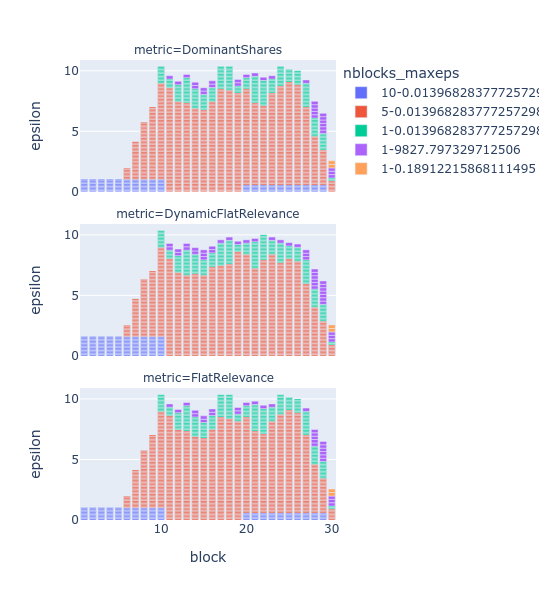

In [38]:
px.bar(
    # df,
    df.query("allocated"),
    x="block",
    y="epsilon",
#     color="log_id",
    color="nblocks_maxeps",
    # barmode="group",
    # pattern_shape="allocated",
    facet_col="metric",
    facet_col_wrap=1,
    height=600,
#     animation_frame="id"
)


In [41]:
df = load_latest_scheduling_results()

/home/pierre/privacypacking/logs/exp_1117-200725/time_based_budget_unlocking_DominantShares/1117-200728_ebfeca.json
/home/pierre/privacypacking/logs/exp_1117-200725/time_based_budget_unlocking_DynamicFlatRelevance/1117-200730_df0a21.json
/home/pierre/privacypacking/logs/exp_1117-200725/time_based_budget_unlocking_FlatRelevance/1117-200730_2f84e7.json


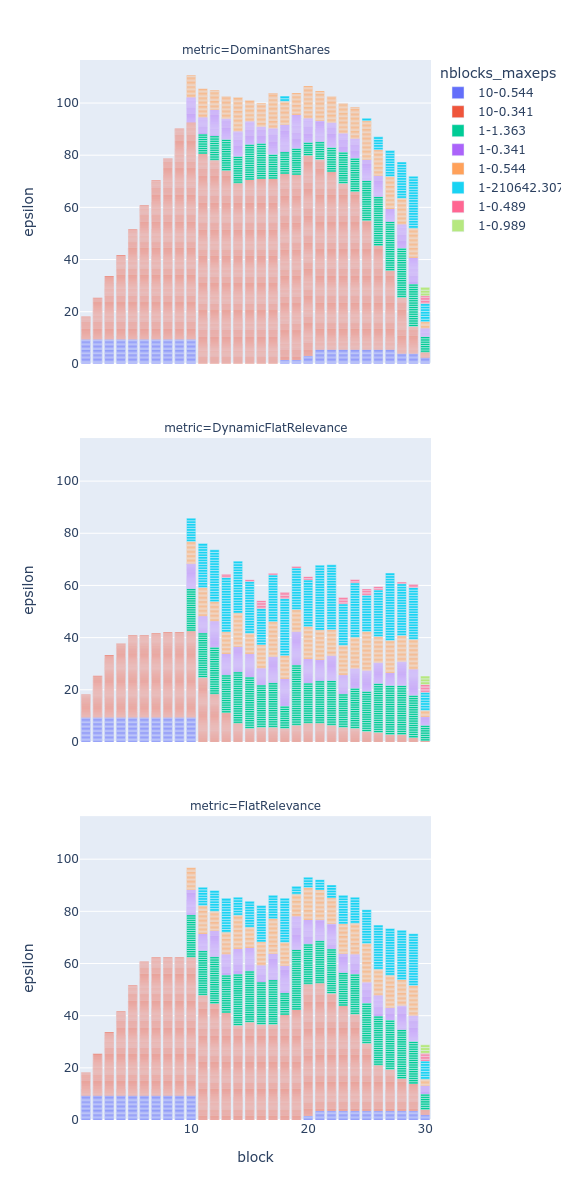

In [43]:
px.bar(
    # df,
    df.query("allocated"),
    x="block",
    y="epsilon",
#     color="log_id",
    color="nblocks_maxeps",
    # barmode="group",
    # pattern_shape="allocated",
    facet_col="metric",
    facet_col_wrap=1,
    height=1200,
#     animation_frame="id"
)

In [68]:
df = load_latest_scheduling_results(alphas=True)

/home/pierre/privacypacking/logs/exp_1117-200725/time_based_budget_unlocking_DominantShares/1117-200728_ebfeca.json
/home/pierre/privacypacking/logs/exp_1117-200725/time_based_budget_unlocking_DynamicFlatRelevance/1117-200730_df0a21.json
/home/pierre/privacypacking/logs/exp_1117-200725/time_based_budget_unlocking_FlatRelevance/1117-200730_2f84e7.json


In [69]:
maxeps = {}
for task_file in Path("/home/pierre/privacypacking/data/mixed_curves/tasks").glob("*.yaml"):
    task_dict = yaml.safe_load(task_file.open("r"))
    maxeps[f"{task_dict['rdp_epsilons'][-1]:.3f}"]=task_file.stem
maxeps

{'0.544': 'subsampled_gaussian_0.5',
 '0.489': 'laplace_0.5',
 '210642.307': 'subsampled_gaussian_1.0',
 '0.989': 'laplace_1.0',
 '1.363': 'gaussian_1.0',
 '0.341': 'gaussian_0.5'}

In [70]:
def get_task_name(s):
    n,m = s.split("-")
    return f"{n}-{maxeps[m]}"

In [71]:
df["task"] = df["nblocks_maxeps"].apply(get_task_name)

In [74]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [106]:
import numpy as np

In [133]:
grouped = df[["id","task","allocated","metric"]].drop_duplicates(subset='id').groupby(["task","metric"]).agg([np.sum, "count"])
grouped

id       allocated      
                                                     sum count       sum count
task                       metric                                             
1-gaussian_0.5             DominantShares        1094700   442       442   442
1-gaussian_1.0             DominantShares         801502   275       275   275
                           DynamicFlatRelevance   204978   124       124   124
1-laplace_0.5              DominantShares         911815   387         5   387
                           DynamicFlatRelevance    84401    31        31    31
1-laplace_1.0              DominantShares        1027097   416         3   416
1-subsampled_gaussian_0.5  DominantShares        1130767   431       431   431
1-subsampled_gaussian_1.0  DominantShares         311152    81        59    81
                           DynamicFlatRelevance   749261   328       328   328
10-gaussian_0.5            DominantShares        1148838   452       407   452
                           FlatRelevance            3086     1         1     1
10-gaussian_1.0            DominantShares        1003017   400         0   400
10-laplace_0.5             DominantShares         928470   401         0   401
10-laplace_1.0             DominantShares        1034041   434         0   434
10-subsampled_gaussian_0.5 DominantShares        1038633   402        30   402
10-subsampled_gaussian_1.0 DominantShares        1025742   395         0   395

In [134]:
grouped = grouped.reset_index()
grouped["n_allocated"] = grouped["allocated"]["sum"]
grouped["total"] = grouped["allocated"]["count"]
grouped = grouped.drop(["id", "allocated"], axis=1)
# grouped["rejected"] = grouped["total"] - grouped["allocated"]

grouped

/home/pierre/.cache/pypoetry/virtualenvs/privacypacking-DDudTmDF-py3.8/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



task                metric n_allocated total
                                                                      
0               1-gaussian_0.5        DominantShares         442   442
1               1-gaussian_1.0        DominantShares         275   275
2               1-gaussian_1.0  DynamicFlatRelevance         124   124
3                1-laplace_0.5        DominantShares           5   387
4                1-laplace_0.5  DynamicFlatRelevance          31    31
5                1-laplace_1.0        DominantShares           3   416
6    1-subsampled_gaussian_0.5        DominantShares         431   431
7    1-subsampled_gaussian_1.0        DominantShares          59    81
8    1-subsampled_gaussian_1.0  DynamicFlatRelevance         328   328
9              10-gaussian_0.5        DominantShares         407   452
10             10-gaussian_0.5         FlatRelevance           1     1
11             10-gaussian_1.0        DominantShares           0   400
12              10-laplace_0.5        DominantShares           0   401
13              10-laplace_1.0        DominantShares           0   434
14  10-subsampled_gaussian_0.5        DominantShares          30   402
15  10-subsampled_gaussian_1.0        DominantShares           0   395

In [137]:
grouped["n_rejected"] = grouped["total"] - grouped["n_allocated"]

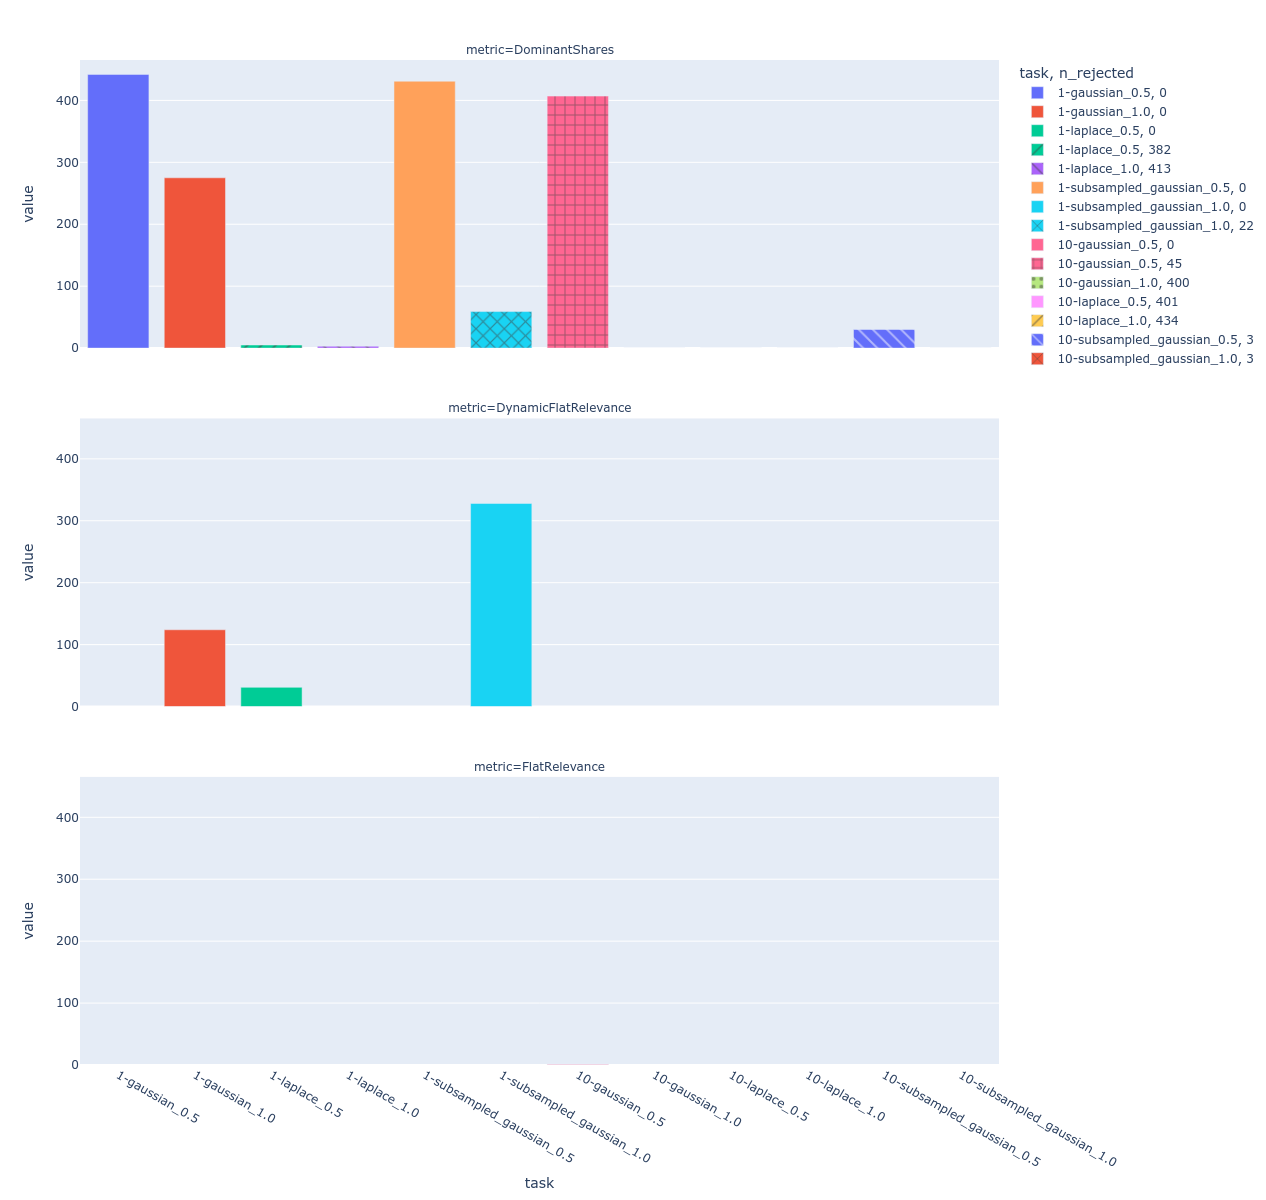

In [141]:
# TODO: stack rejected
px.bar(
    # df,
    grouped,
    x="task",
    y=["n_allocated", "n_rejected"],
    # range_y=[0,3],
#     color="log_id",
    color="task",
    # barmode="group",
    pattern_shape="n_rejected",
    facet_col="metric",
    facet_col_wrap=1,
    height=1200,
#     animation_frame="id"
)

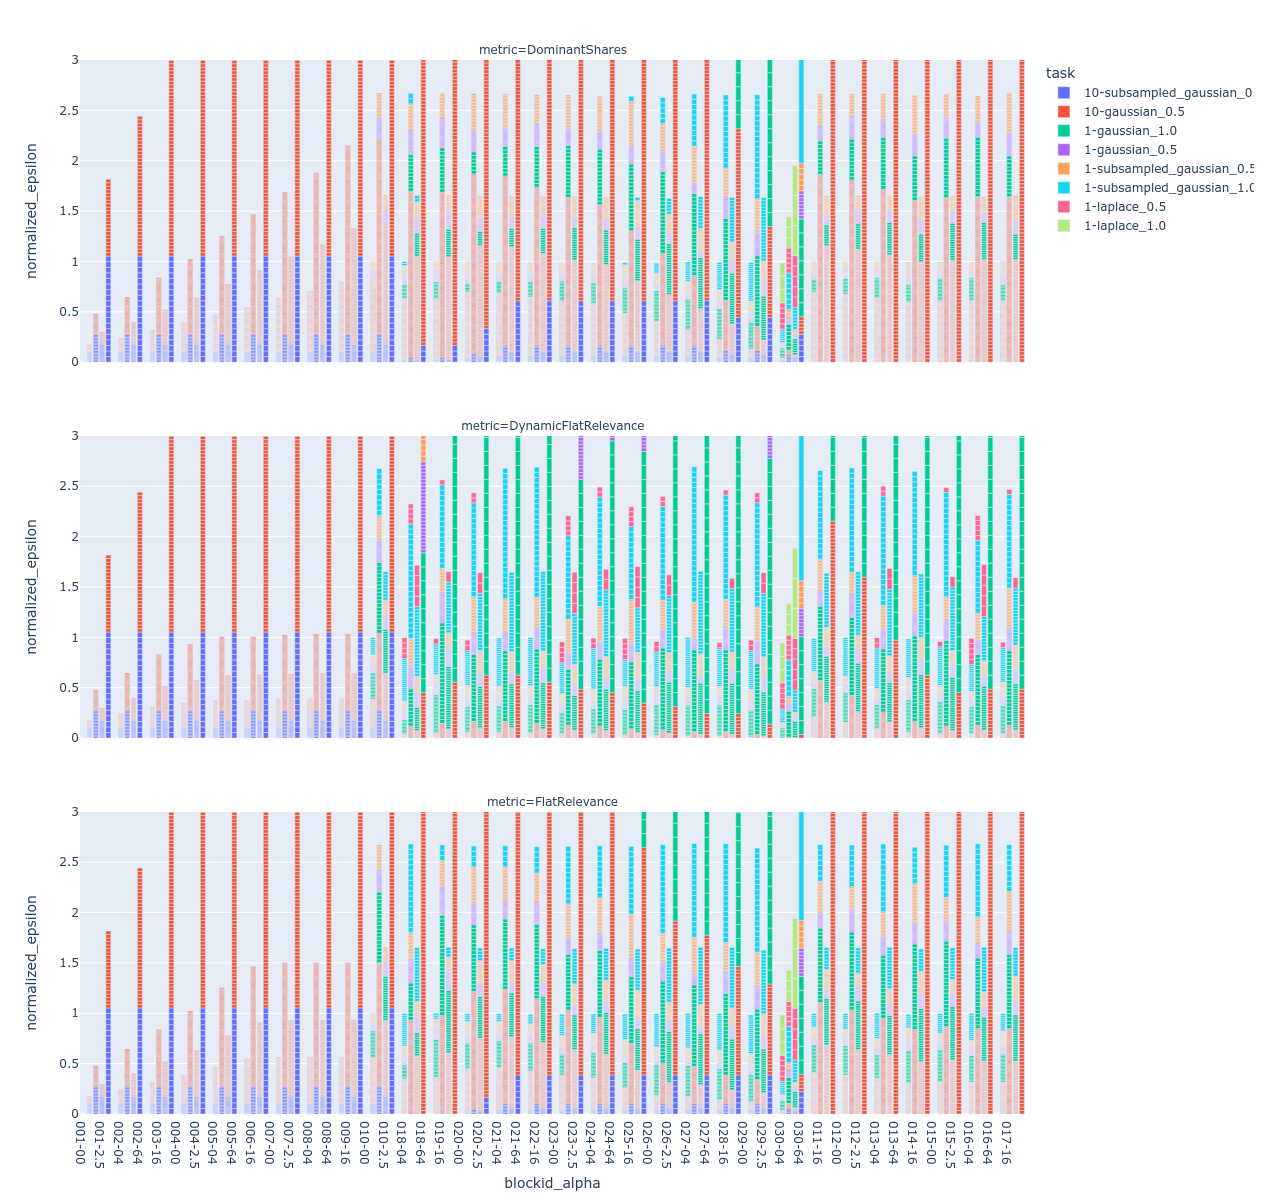

In [72]:
px.bar(
    # df,
    df.query("allocated"),
    x="blockid_alpha",
    y="normalized_epsilon",
    range_y=[0,3],
#     color="log_id",
    color="task",
    # barmode="group",
    # pattern_shape="allocated",
    facet_col="metric",
    facet_col_wrap=1,
    height=1200,
#     animation_frame="id"
)